In [80]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [81]:
import numpy as np
import pandas as pd

In [82]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [83]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [84]:
engine = create_engine("sqlite:///./raw_data/hawaii.sqlite")

In [85]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [86]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [87]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [88]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [89]:
conn=engine.connect()
data = pd.read_sql("SELECT * FROM Measurement", conn)
data

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


# Exploratory Climate Analysis

In [90]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lim_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lim1y_date=func.strftime("%Y-%m-%d",lim_date)
lim1y_date=lim1y_date-dt.timedelta(days=365)
lim1y_date



In [91]:
# Calculate the date 1 year ago from the last data point in the database
lim_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(lim_date)

('2017-08-23',)


In [92]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precip=session.query(Measurement.date, Measurement.prcp).filter(func.strftime("%Y-%m-%d",Measurement.date)>="2016-08-24")
precip=pd.DataFrame(precip,columns=['date','prcp']).set_index('date').sort_index()
precip=precip.dropna()
precip

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


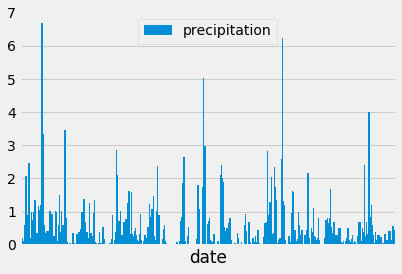

In [93]:
# Use Pandas Plotting with Matplotlib to plot the data

precip.plot.bar(width=8)
plt.xticks([])
plt.grid(True, which='major', axis='x')
plt.legend(['precipitation'],loc='upper center')
plt.show()


In [94]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [95]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [96]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel=[
    Measurement.station,
    func.count(Measurement.tobs)
]
session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [97]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel=[
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
]
session.query(*sel).filter(Measurement.station=="USC00519281").first()

(54.0, 85.0, 71.66378066378067)

In [98]:
session.query(Measurement.date).filter(Measurement.station=="USC00519281").order_by(Measurement.date.desc()).first()

('2017-08-18')

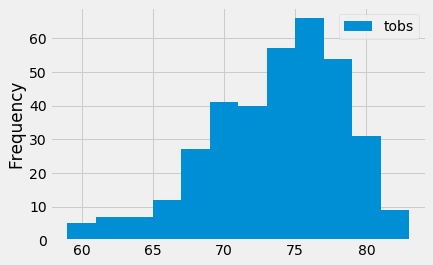

In [99]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobsdata=pd.DataFrame(session.query(Measurement.tobs).filter(Measurement.station=="USC00519281").filter(func.strftime("%Y-%m-%d",Measurement.date)>="2016-08-19").order_by(Measurement.date.desc()).all())
tobsdata.hist(bins=12)
plt.ylabel("Frequency")
plt.title("")
plt.legend(["tobs"])